# Lab 8: Bias in Algorithms

## Methods/concepts: algorithmic bias; choice of “labels” vs. “predictors”

**Name:** Shreya Chaturvedi

**Email:** shreyachaturvedi@hks.harvard.edu

**HUID:** 31575036

**Lab:** Thursday 3pm at HKS

**Date:** April 10th, 2024

**LAB DESCRIPTION**

In this lab, we will dive deeper into bias in algorithms, following
[Obermeyer, Powers, Vogeli, and Mullainathan
(2019](https://science-sciencemag-org.ezp-prod1.hul.harvard.edu/content/366/6464/447)).
We will train several prediction algorithms, some including the
patient’s race and others explicitly leaving out the patient’s race. We
will see how the choice of “label” – either patient costs or patient
health – affects the performance of the models. Finally, we will examine
the racial composition of patients predicted to have high risk according
to the algorithms. For more details on the variables
included in these data, see [Table 1](#Table1).

A list and description of each of the R
commands needed for questions 6 through 9 on this lab are contained in
[Table 2](#Table2).

## **QUESTIONS**

1.  Start by randomly splitting the 48,748 patients included in the
    **health.dta** data set into a **10%** training data set and a
    **90%** test data set. [Table 1](#table1) describes the data. There
    are two reasons we are using such a small fraction of the data to
    train the models. First, estimating random forests on a larger
    fraction of the data would be prohibitively time consuming. Second,
    we require a large number of observations in the test data set so
    that we can study differences in risk score by race.

In [1]:
# #  The following program starts by loading in the health data and dividing it
# #  into a 10% training sample and a 90% test sample.  It then estimates
# #  four random forests models that differ in the predictor variables includes
# #  and the "label" or outcome variable that the models predict.  The next part
# #  of the code computes RMSPEs for the four models.  The last part of the code
# #  exports the predictions of the four models for the test sample as "lab8_2024_results.dta"
# #
# #  You will analyze the resulting "lab8_2024_results.dta" data set to answer questions
# #  6-9 on the lab.  The starter code helps out for questions 1-5.
# #
# #  The code may have some typos -- please be on the look out for them -- and to 
# #  receive credit for the lab you have to make edits to estimate your own 
# #  random forests.  These are simply examples of what you might
# #  want to  do in your analysis, but you are expected to make an effort to 
# #  understand what you are doing with the code.
# #
# #  Inputs:  health.dta (download from canvas)
# #           randomForest to estimate random forest models
# #           tidyverse library for data manipulations
# #           haven library to load stata data sets into R
# #
# #  Outputs: mod1_importance.png
# #           mod2_importance.png
# #           mod3_importance.png
# #           mod4_importance.png
# #           lab8_2024_results.dta

# # Question 1 example code
# rm(list=ls()) # removes all objects from the environment 

# # Install packages (if necessary) and load required libraries
# if (!require(haven)) install.packages("haven"); library(haven)
# if (!require(randomForest)) install.packages("randomForest"); library(randomForest)
# if (!require(tidyverse)) install.packages("tidyverse"); library(tidyverse)

# #Set seed for cross validation and random forests
# HUID <- 31575036 #Replace with your HUID
# set.seed(HUID)

# #-------------------------------------------------------------------------------
# # Data set up
# #-------------------------------------------------------------------------------

# #Open stata data set
# download.file("https://raw.githubusercontent.com/ekassos/ec50_s24/main/health.dta", "health.dta", mode = "wb")
# dat <- read_dta("health.dta")
# head(dat)

# #Store health variables from time t-1 which all end with _tm
# all_predictors <- colnames(dat[,grep("^[tm1]", names(dat))])
# #all_predictors

# #Store predictor variables which all start with P_*, but EXCLUDE race
# race <- c("tm1_dem_black")
# exclude_race <- setdiff(all_predictors,race)
# #exclude_race

# #Define training and test data sets
# #Use a uniformly distributed random number between 0 and 1
# dat$random_number <- runif(length(dat$patient_id))

# ## Generate a training flag for 10% of the sample
# dat$train_flag <- ifelse(dat$random_number<= 0.1, 1, 0) 

# #Report number of observations in training and test samples
# sum(dat$train_flag)
# sum(1-dat$train_flag)

# ## Create some data frames that just contain the training and test data

# #Data frame with training data (randomly selected 10% of the data)
# training <- subset(dat, train_flag == 1)
# summary(training)

# #Data frame with test data (remaining 90% of the data)
# test <- subset(dat, train_flag == 0)
# summary(test)

In [2]:
## YOUR QUESTION 1 CODE GOES HERE
# Remove all existing objects from the workspace for a clean start
rm(list = ls())

# Load required packages, installing them if they are not already installed
if (!require("haven")) install.packages("haven")
library(haven)
if (!require("randomForest")) install.packages("randomForest")
library(randomForest)
if (!require("dplyr")) install.packages("dplyr")
library(dplyr)
if (!require("ggplot2")) install.packages("ggplot2")
library(ggplot2)

# Set a seed for reproducibility
set.seed(31575036)  # Use your HUID or any unique ID

# Load the dataset
download.file("https://raw.githubusercontent.com/ekassos/ec50_s24/main/health.dta", "health.dta", mode = "wb")
health_data <- read_dta("health.dta")

# Divide data into a 10% training sample and a 90% test sample
health_data$random_number <- runif(n = nrow(health_data))
train_flag <- ifelse(health_data$random_number <= 0.1, TRUE, FALSE)
training_data <- health_data[train_flag, ]
test_data <- health_data[!train_flag, ]

# Identify predictor variables excluding patient's race
exclude_race <- names(health_data)[grepl("^tm1", names(health_data)) & !grepl("tm1_dem_black", names(health_data))]
all_predictors <- names(health_data)[grepl("^tm1", names(health_data))]

# Define outcome variable
outcome_var <- "cost_t"  # For models predicting costs
health_outcome_var <- "gagne_sum_t"  # For models predicting health


Loading required package: haven

Loading required package: randomForest

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




**Question 1 Answer**

Example code commented out and modified code given above.

2.  Estimate the following statistical models using the training data
    set:

    1. Random forest to predict the “label” of patient costs (cost_t) using the full set of predictors consisting of all variables starting with tm1\_, but *excluding* the patient’s race
    2. Random forest to predict the “label” of patient costs (cost_t) using the full predictor set, now *including* the patient’s race
    3. Random forest to predict the “label” of patient health (gagne_sum_t) using the full predictor set, *excluding* the patient’s race
    4. Random forest to predict the “label” of patient health (gagne_sum_t) using the full predictor set, *including* the patient’s race


    Note that random forests with lots of observations and predictors (150) will take a long time to run. You should therefore only use around 100 trees in your forests.

In [3]:
# #-------------------------------------------------------------------------------
# # Model 1: Random forest trained to predict costs, using all predictors, 
# # EXCLUDING patient's race 
# #-------------------------------------------------------------------------------

# #Reformulate allows us to write yvar ~ xvar1 + xvar2 + ... using a list of all
# #the xvar1, xvar2, etc. variables without actually writing them out
# mod1 <- randomForest(reformulate(exclude_race, "cost_t"), 
#                      ntree=100, 
#                      mtry=149,
#                      importance=TRUE, ## add importance=TRUE so that we store the variable importance information
#                      data=training)

# #Tuning parameters are ntree and mtry
# #ntree is number of trees in your forest
# #mtry is the number of predictors considered at each split (default is number of predictors divided by 3)

# ### Try changing mtry and ntree

# mod1 #Review the Random Forest Results

# ### generate predictions for all observations in test and training samples
# y_test_predictions_mod1 <- predict(mod1, newdata=test)
# y_train_predictions_mod1 <- predict(mod1, newdata=training)

# #Variable importance
# importance(mod1)
# varImpPlot(mod1, type=1) #Plot the Random Forest Results
# dev.copy(png,'mod1_importance.png')
# dev.off()

# #type	is either 1 or 2, specifying the type of importance measure 
# #(1=mean decrease in accuracy, 2=mean decrease in node impurity)




# #-------------------------------------------------------------------------------
# # Model 2: Random forest trained to predict costs, using all predictors, 
# # INCLUDING patient's race 
# #-------------------------------------------------------------------------------

# #Reformulate allows us to write yvar ~ xvar1 + xvar2 + ... using a list of all
# #the xvar1, xvar2, etc. variables without actually writing them out
# mod2 <- randomForest(reformulate(all_predictors, "cost_t"), 
#                      ntree=100, 
#                      mtry=150,
#                      importance=TRUE, ## add importance=TRUE so that we store the variable importance information
#                      data=training)

# #Tuning parameters are ntree and mtry
# #ntree is number of trees in your forest
# #mtry is the number of predictors considered at each split (default is number of predictors divided by 3)

# ### Try changing mtry and ntree

# mod2 #Review the Random Forest Results

# ### generate predictions for all observations in test and training samples
# y_train_predictions_mod2 <- predict(mod2, newdata=training)
# y_test_predictions_mod2 <- predict(mod2, newdata=test)

# #Variable importance
# importance(mod2)
# varImpPlot(mod2, type=1) #Plot the Random Forest Results
# dev.copy(png,'mod2_importance.png')
# dev.off()


# #type	is either 1 or 2, specifying the type of importance measure 
# #(1=mean decrease in accuracy, 2=mean decrease in node impurity)

# #-------------------------------------------------------------------------------
# # Model 3: Random forest trained to predict health, using all predictors, 
# # EXCLUDING patient's race 
# #-------------------------------------------------------------------------------

# #Reformulate allows us to write yvar ~ xvar1 + xvar2 + ... using a list of all
# #the xvar1, xvar2, etc. variables without actually writing them out
# mod3 <- randomForest(reformulate(exclude_race, "gagne_sum_t"), 
#                         ntree=100, 
#                         mtry=149,
#                         importance=TRUE, ## add importance=TRUE so that we store the variable importance information
#                         data=training)

# #Tuning parameters are ntree and mtry
# #ntree is number of trees in your forest
# #mtry is the number of predictors considered at each split (default is number of predictors divided by 3)

# ### Try changing mtry and ntree

# mod3 #Review the Random Forest Results

# ### generate predictions for all observations in test and training samples
# y_test_predictions_mod3 <- predict(mod3, newdata=test)
# y_train_predictions_mod3 <- predict(mod3, newdata=training)


# #Variable importance
# importance(mod3)
# varImpPlot(mod3, type=1) #Plot the Random Forest Results
# dev.copy(png,'mod3_importance.png')
# dev.off()

# #type	is either 1 or 2, specifying the type of importance measure 
# #(1=mean decrease in accuracy, 2=mean decrease in node impurity)

# #-------------------------------------------------------------------------------
# # Model 4: Random forest trained to predict health, using all predictors, 
# # INCLUDING patient's race 
# #-------------------------------------------------------------------------------

# #Reformulate allows us to write yvar ~ xvar1 + xvar2 + ... using a list of all
# #the xvar1, xvar2, etc. variables without actually writing them out
# mod4 <- randomForest(reformulate(all_predictors, "gagne_sum_t"), 
#                      ntree=100, 
#                      mtry=150,
#                      importance=TRUE, ## add importance=TRUE so that we store the variable importance information
#                      data=training)

# #Tuning parameters are ntree and mtry
# #ntree is number of trees in your forest
# #mtry is the number of predictors considered at each split (default is number of predictors divided by 3)

# ### Try changing mtry and ntree

# mod4 #Review the Random Forest Results

# ### generate predictions for all observations in test and training samples
# y_train_predictions_mod4 <- predict(mod4, newdata=training)
# y_test_predictions_mod4 <- predict(mod4, newdata=test)

# #Variable importance
# importance(mod4)
# varImpPlot(mod4, type=1) #Plot the Random Forest Results
# dev.copy(png,'mod4_importance.png')
# dev.off()


# #type	is either 1 or 2, specifying the type of importance measure 
# #(1=mean decrease in accuracy, 2=mean decrease in node impurity)

In [ ]:
## YOUR QUESTION 2 CODE GOES HERE
# Model 1: Predicting costs excluding race
mod1 <- randomForest(as.formula(paste(outcome_var, "~", paste(exclude_race, collapse="+"))), data=training_data, ntree=100, mtry=round(length(exclude_race)/3), importance=TRUE)

# Model 2: Predicting costs including race
mod2 <- randomForest(as.formula(paste(outcome_var, "~", paste(all_predictors, collapse="+"))), data=training_data, ntree=100, mtry=round(length(all_predictors)/3), importance=TRUE)

# Model 3: Predicting health excluding race
mod3 <- randomForest(as.formula(paste(health_outcome_var, "~", paste(exclude_race, collapse="+"))), data=training_data, ntree=100, mtry=round(length(exclude_race)/3), importance=TRUE)

# Model 4: Predicting health including race
mod4 <- randomForest(as.formula(paste(health_outcome_var, "~", paste(all_predictors, collapse="+"))), data=training_data, ntree=100, mtry=round(length(all_predictors)/3), importance=TRUE)

# Variable importance plots
varImpPlot(mod1, type=1, main="Model 1 Variable Importance")
ggsave("mod1_importance.png")

varImpPlot(mod2, type=1, main="Model 2 Variable Importance")
ggsave("mod2_importance.png")

varImpPlot(mod3, type=1, main="Model 3 Variable Importance")
ggsave("mod3_importance.png")

varImpPlot(mod4, type=1, main="Model 4 Variable Importance")
ggsave("mod4_importance.png")

# Export predictions for the train and test sample
y_train_predictions_mod1 <- predict(mod1, newdata=training_data)
y_test_predictions_mod1 <- predict(mod1, newdata=test_data)

y_train_predictions_mod2 <- predict(mod2, newdata=training_data)
y_test_predictions_mod2 <- predict(mod2, newdata=test_data)

y_train_predictions_mod3 <- predict(mod3, newdata=training_data)
y_test_predictions_mod3 <- predict(mod3, newdata=test_data)

y_train_predictions_mod4 <- predict(mod4, newdata=training_data)
y_test_predictions_mod4 <- predict(mod4, newdata=test_data)

# Save the results
write_dta(test_data, "lab8_2024_results.dta")


**Question 2 Answer**

Example code commented out and modified code given above.

3.  Calculate and compare the root mean squared prediction error for
    your models that include patient race vs. those that exclude patient
    race in the **training sample**.

In [ ]:
#-------------------------------------------------------------------------------
# Compare RMSE for models 1-4
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Calculate and compare the mean squared error in the training sample: 
#-------------------------------------------------------------------------------

## Root mean squared prediction error in  the training sample.
p <- 4
RMSPE <- matrix(0, p, 1)

## Model 1
RMSPE[1] <- sqrt(mean((training_data$cost_t - y_train_predictions_mod1)^2, na.rm=TRUE))

## Model 2
RMSPE[2] <- sqrt(mean((training_data$cost_t - y_train_predictions_mod2)^2, na.rm=TRUE))

## Model 3 
RMSPE[3] <- sqrt(mean((training_data$gagne_sum_t - y_train_predictions_mod3)^2, na.rm=TRUE))

## Model 4
RMSPE[4] <- sqrt(mean((training_data$gagne_sum_t - y_train_predictions_mod4)^2, na.rm=TRUE))

#Display a table of the results
data.frame(algorithm = c("Model 1 - Costs (excl. race) ", 
                             "Model 2 - Costs (incl. race) ",
                             "Model 3 - Health (excl. race)",
                             "Model 4 - Health (incl. race)"),
           RMSPE)


**Question 3 Answer**

RMSPE given above. 

4.  Calculate and compare the root mean squared prediction error for
    your models that include patient race vs. those that exclude patient
    race in the **test sample**.

In [ ]:
#-------------------------------------------------------------------------------
# Calculate and compare the mean squared error in  the lock box data 
#-------------------------------------------------------------------------------

## Root mean squared prediction error in the test sample.
p <- 4
RMSPE_OOS <- matrix(0, p, 1)

## Model 1
RMSPE_OOS[1] <- sqrt(mean((test_data$cost_t - y_test_predictions_mod1)^2, na.rm=TRUE))

## Model 2
RMSPE_OOS[2] <- sqrt(mean((test_data$cost_t - y_test_predictions_mod2)^2, na.rm=TRUE))

## Model 3
RMSPE_OOS[3] <- sqrt(mean((test_data$gagne_sum_t - y_test_predictions_mod3)^2, na.rm=TRUE))

## Model 4
RMSPE_OOS[4] <- sqrt(mean((test_data$gagne_sum_t - y_test_predictions_mod4)^2, na.rm=TRUE))


#Display a table of the results
data.frame(algorithm = c("Model 1 - Costs (excl. race) ", 
                         "Model 2 - Costs (incl. race) ",
                         "Model 3 - Health (excl. race)",
                         "Model 4 - Health (incl. race)"),
           RMSPE_OOS)

**Question 4 Answer**

RMPSE given above.

5. Export a data set with **the test data** and your predictions as a
    .dta file. If you are in a Stata lab, you can exit Python and load
    this file into Stata for further analysis.

In [ ]:
#-------------------------------------------------------------------------------
# Export test data set with predictions
#-------------------------------------------------------------------------------

#Export data set with training data + predictions from the models
lab8 <- test_data

lab8$y_test_predictions_mod1 <- y_test_predictions_mod1
lab8$y_test_predictions_mod2 <- y_test_predictions_mod2
lab8$y_test_predictions_mod3 <- y_test_predictions_mod3
lab8$y_test_predictions_mod4 <- y_test_predictions_mod4

write_dta(lab8, "lab8_2024_results.dta")

**Question 5 Answer**

(Answer here; include your images if needed.)

6. As in Lab 1 and Lab 2, convert the predictions in the test sample from each of your prediction algorithms into percentile ranks, normalized so that the top rank is equal to 100.  The percentile rank is the “risk score” from the algorithm.

In [ ]:
# QUESTION 6 Code
# Calculate percentile ranks for predictions from each model and normalize so top rank equals 100
test_data <- test_data %>%
  mutate(
    prediction_mod1_rank = ntile(-y_test_predictions_mod1, 100),  # Use negative to rank highest prediction as 100
    prediction_mod2_rank = ntile(-y_test_predictions_mod2, 100),
    prediction_mod3_rank = ntile(-y_test_predictions_mod3, 100),
    prediction_mod4_rank = ntile(-y_test_predictions_mod4, 100)
  )

# Since ntile ranks from 1 to 100 (with 1 being the lowest), to make 100 the highest score, we subtract each rank from 101
test_data <- test_data %>%
  mutate(
    prediction_mod1_rank = 101 - prediction_mod1_rank,
    prediction_mod2_rank = 101 - prediction_mod2_rank,
    prediction_mod3_rank = 101 - prediction_mod3_rank,
    prediction_mod4_rank = 101 - prediction_mod4_rank
  )

# View the first few rows to confirm the changes
head(test_data)
summary(test_data$prediction_mod1_rank)
summary(test_data$prediction_mod2_rank)
summary(test_data$prediction_mod3_rank)
summary(test_data$prediction_mod4_rank)

**Question 6 Answer**

Code given above.

7. Now consider a program that makes patients eligible for extra
    resources if their “risk score” is above the 55th percentile. (This
    corresponds to the top 45 percent of risk scores).
   1. As on lab 1 and 2, start by defining four new indicator variables corresponding to whether the risk score from each model is strictly greater than 55.
   2. What fraction of all Black patients would be eligible for the program using each of the four algorithms? To answer this question, report the means of the indicator variables you created in (a) after subsetting the data to Black patients (i.e., `tm1_dem_black == 1`).
   3. Among patients eligible for the program, what fraction are Black? To answer this question, report the mean of the indicator variable `tm1_dem_black` after subseting the data to patients eligible for the program for model 1. Then repeat for models 2, 3, and 4.

In [ ]:
# QUESTION 7 Code
test_data <- test_data %>%
  mutate(eligible_model1 = ifelse(prediction_mod1_rank > 55, 1, 0),
         eligible_model2 = ifelse(prediction_mod2_rank > 55, 1, 0),
         eligible_model3 = ifelse(prediction_mod3_rank > 55, 1, 0),
         eligible_model4 = ifelse(prediction_mod4_rank > 55, 1, 0))

df_black <- test_data %>% filter(tm1_dem_black == 1)

mean_eligible_black <- sapply(df_black[, c("eligible_model1", "eligible_model2", "eligible_model3", "eligible_model4")], mean)
mean_eligible_black

fraction_black_eligible <- sapply(1:4, function(i) {
  df_eligible <- test_data %>% filter(.[[paste0("eligible_model", i)]] == 1)
  mean(df_eligible$tm1_dem_black, na.rm = TRUE)
})
fraction_black_eligible


**Question 7 Answer**

A. Code given above.

B. Share of eligible black patients as given:
Model 1: 0.517
Model 2: 0.526
Model 3: 0.588
Model 4: 0.616

C. Fraction of eligible that are black as given: 
Model 1: 0.131
Model 2: 0.134
Model 3: 0.149
Model 4: 0.156


8. Now we will replicate the key figures from [Obermeyer, Powers,
    Vogeli, and Mullainathan
    (2019](https://science-sciencemag-org.ezp-prod1.hul.harvard.edu/content/366/6464/447)).
    Produce binned scatter plots of patient costs and patient health vs.
    the percentile rank “risk score” from each algorithm, with White and
    Black patients plotted separately. This is a total of 8 graphs: 4
    models x 2 outcomes.

   In R, you could do the same in ggplot by using the geom="line" option and geom="point" option in stat_binmean from the statar package, and set the color option to the race variable to plot Black and White patients separately:

   ```
   ggplot(dat, aes(x = percentile_rank , y = outcome_variable, color = race)) +
   stat_binmean(n = 20, geom = "line") +
   stat_binmean(n = 20, geom = "point")
   ```

In [ ]:
# QUESTION 8 Code
# Convert the race variable to a factor with descriptive labels in test_data
test_data$race <- factor(test_data$tm1_dem_black, labels = c("White", "Black"))

# Plot for Model 1 - Patient Costs
ggplot(test_data, aes(x = prediction_mod1_rank, y = cost_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Costs vs. Percentile Rank by Race - Model 1",
       x = "Percentile Rank", y = "Patient Costs") +
  theme_minimal()

# Plot for Model 1 - Patient Health
ggplot(test_data, aes(x = prediction_mod1_rank, y = gagne_sum_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Health vs. Percentile Rank by Race - Model 1",
       x = "Percentile Rank", y = "Patient Health") +
  theme_minimal()

# Plot for Model 2 - Patient Costs
ggplot(test_data, aes(x = prediction_mod2_rank, y = cost_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Costs vs. Percentile Rank by Race - Model 2",
       x = "Percentile Rank", y = "Patient Costs") +
  theme_minimal()

# Plot for Model 2 - Patient Health
ggplot(test_data, aes(x = prediction_mod2_rank, y = gagne_sum_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Health vs. Percentile Rank by Race - Model 2",
       x = "Percentile Rank", y = "Patient Health") +
  theme_minimal()

# Plot for Model 3 - Patient Costs
ggplot(test_data, aes(x = prediction_mod3_rank, y = cost_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Costs vs. Percentile Rank by Race - Model 3",
       x = "Percentile Rank", y = "Patient Costs") +
  theme_minimal()

# Plot for Model 3 - Patient Health
ggplot(test_data, aes(x = prediction_mod3_rank, y = gagne_sum_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Health vs. Percentile Rank by Race - Model 3",
       x = "Percentile Rank", y = "Patient Health") +
  theme_minimal()

# Plot for Model 4 - Patient Costs
ggplot(test_data, aes(x = prediction_mod4_rank, y = cost_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Costs vs. Percentile Rank by Race - Model 4",
       x = "Percentile Rank", y = "Patient Costs") +
  theme_minimal()

# Plot for Model 4 - Patient Health
ggplot(test_data, aes(x = prediction_mod4_rank, y = gagne_sum_t, color = race)) +
  stat_summary_bin(fun = "mean", bins = 20, geom = "line") +
  stat_summary_bin(fun = "mean", bins = 20, geom = "point") +
  labs(title = "Patient Health vs. Percentile Rank by Race - Model 4",
       x = "Percentile Rank", y = "Patient Health") +
  theme_minimal()

**Question 8 Answer**

(Answer here; include your images if needed.)

9. In the pre-recorded video for this lab, Professor Ziad Obermeyer
    said that it is the left-hand side variable (i.e., the “label” or
    target parameter) that is the source of bias in algorithms, not the
    right-hand side variables (i.e., the predictors). Explain what he
    meant, and evaluate whether you agree with him using your binned
    scatters above.

   

In [ ]:
# QUESTION 9 Code



**Question 9 Answer**

Professor Obermeyer is referring to the idea that bias in predictive algorithms often stems from the target variable used in the model, rather than the predictors. In other words, if the outcome being predicted is itself a result of biased processes or decisions, then the algorithm, even if it uses unbiased predictors, will perpetuate or even amplify that bias.

From the binned scatter plots above, we can examine this concept. If the outcome variable, such as patient cost or health, has historically been influenced by biased treatment decisions, measurement methods, or systematic inequalities, then models trained to predict these outcomes will reflect those biases. This can happen even if the predictors do not directly include race or other sensitive attributes because the outcome variable effectively "encodes" the bias. In the graphs shown, if there's a consistent discrepancy between the risk scores and actual costs or health outcomes for Black and White patients, especially at similar percentile ranks, this might suggest that the model is reflecting biases in the target parameter.

For instance, if we see that at the same percentile rank, Black patients consistently have higher costs or worse health outcomes compared to White patients, this might indicate that the health outcomes or costs have been influenced by external biased factors which are now being captured by the model. While this holds in some plots (for instance, patient health in model 2), it is not always the case and would require further investigation I think.

10.  Create an annotated/commented do-file, .ipynb Jupyter Notebook, or
    .R file that can replicate all your analyses above. This will be the
    final code that you submit on Gradescope. The motivation for using
    do-files and .R files is described on [page 4](#Dofiles), which has
    been adapted from training materials used by [Innovations for
    Poverty Action (IPA)](https://www.poverty-action.org/) and the
    [Abdul Latif Jameel Poverty Action Lab
    (J-PAL)](https://www.povertyactionlab.org/).


**Final Submission Checklist for Lab 8**

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 49%" />
</colgroup>
<thead>
<tr class="header">
<th><strong>If you’re working with R</strong></th>
<th><strong>If you’re working with Stata</strong></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td><p>Lab 8 Write-Up:</p>
<ul>
<li><p><strong>PDF</strong> of your answers. For graphs, you must save them as images (e.g., .png files) and insert them into the document.</p></li>
</ul>
<p>Lab 8 Code:</p>
<ul>
<li><p><strong>.R script file</strong>, well-annotated replicating all your analyses;<br/><br/>OR</p></li>
<li><p><strong>.ipynb file</strong> and <strong>a .PDF version of this file</strong>.</p></li>
</ul></td>
<td><p>Lab 8 Write-Up:</p>
<ul>
<li><p><strong>PDF</strong> of your answers. For graphs, you must save them as images (e.g., .png files) and insert them into the document.</p></li>
</ul>
<p>Lab 8 Code:</p>
<ul>
<li><p><strong>do-file</strong>, well-annotated replicating all your analyses;<br/><br/>AND</p></li>
<li><p><strong>log-file, not a .smcl file,</strong> with the log showing the output generated by your final do-file.</p></li>
</ul></td>
</tr>
</tbody>
</table>

***If you’re working with an .ipynb notebook***

It is likely that your .ipynb file will be greater than 1 MB in size.
Therefore, for this assignment please submit both your *well-annotated*
**.ipynb file** and **a .PDF version of this file**. The notebook should
replicate all your analyses for Lab 5 (with enough comments that a
principal investigator on a research project would be able to follow and
understand what each step of the code is doing).

## How to submit your assignment

|  |  |
|--|--|
| **Step 1** <br><br> Access the lab assignment under the “Assignments” tab on Canvas| 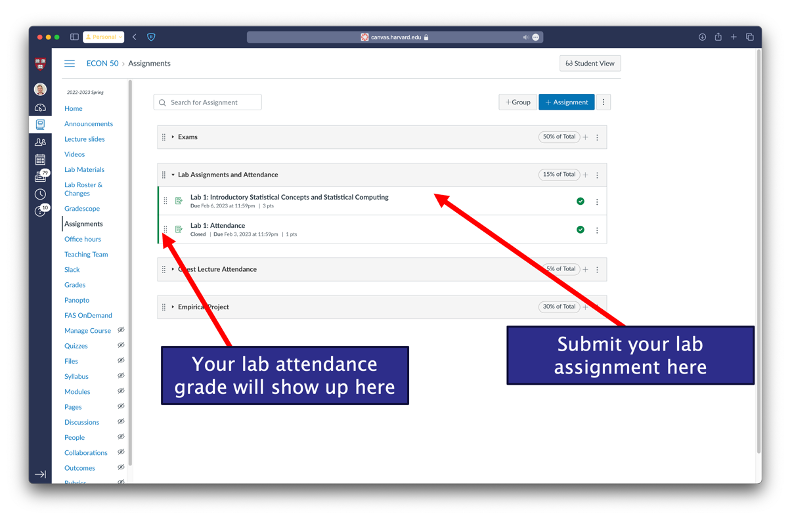 |
| **Step 2** <br><br> Access Gradescope from Canvas| 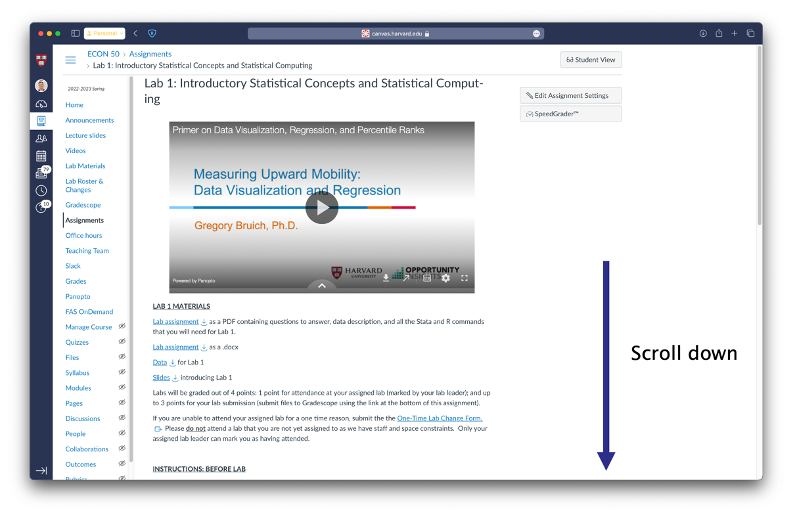 <br> 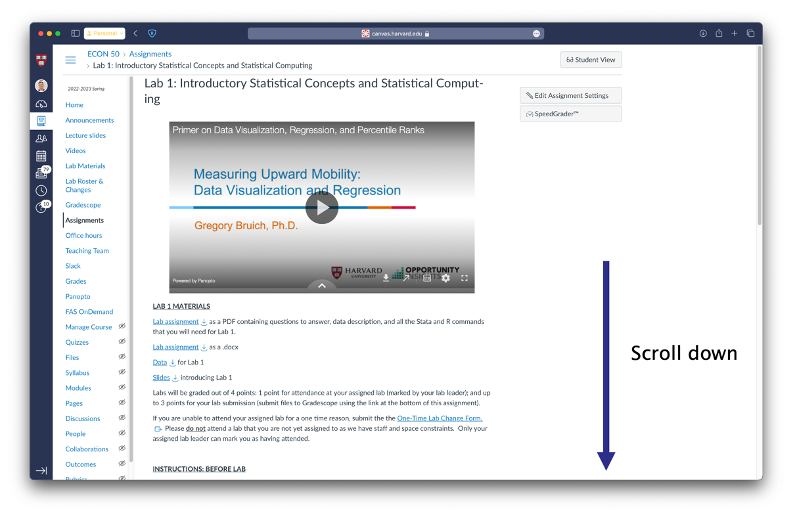|
| **Step 3** <br><br> Access the lab assignment on Gradescope| 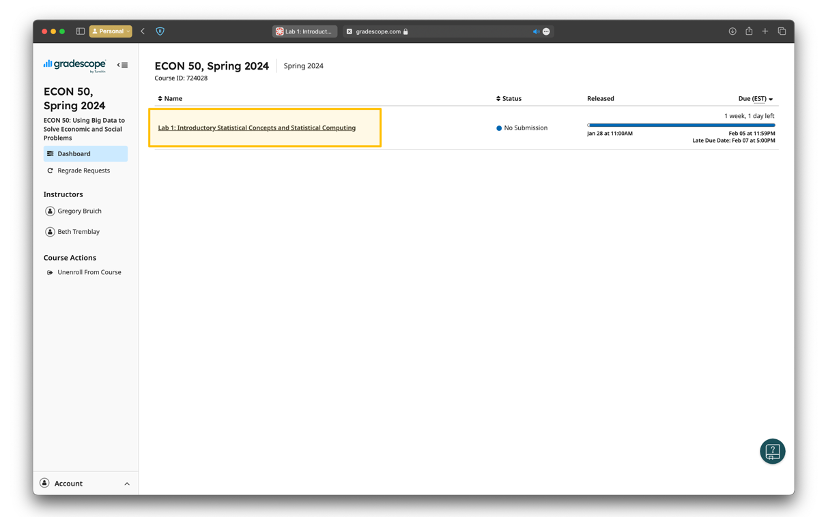 |
| **Step 4** <br><br> Upload your files<br><br> *Check [What files to submit](#What-files-to-submit) to confirm what files you need to submit.*| 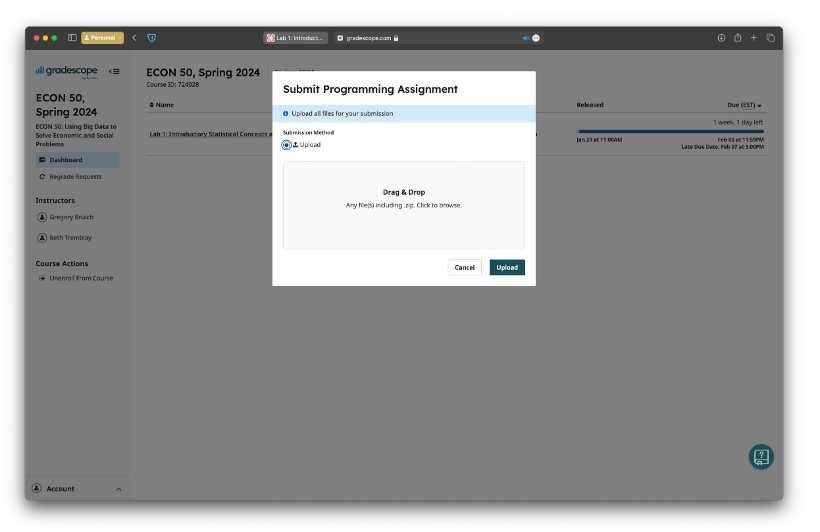 |
| **Step 5** <br><br> What you’ll see after submitting your lab assignment| 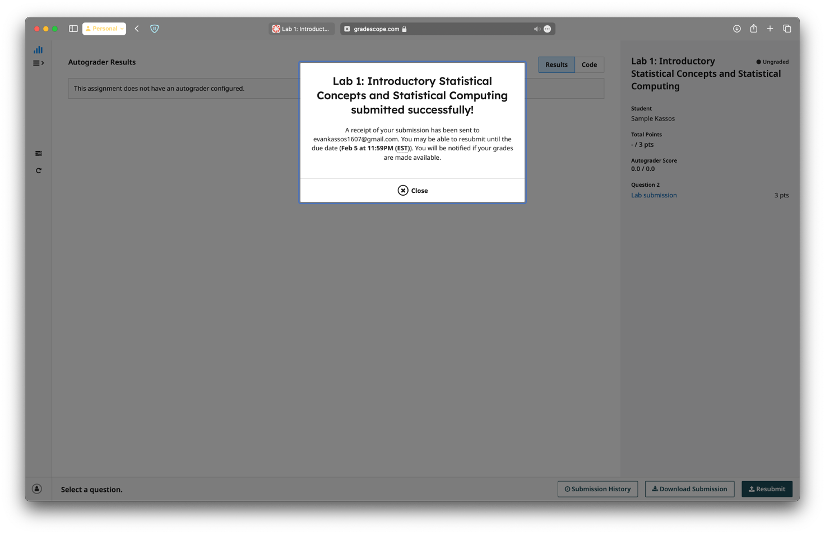 |
| **Step 6** <br><br> Check your submitted files| 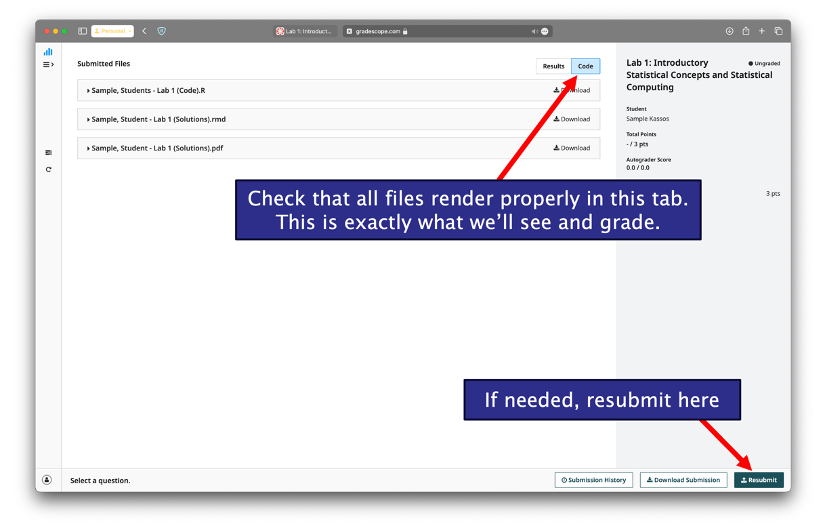 |
| **Step 7** <br><br> You’ll receive an email confirmation as well| 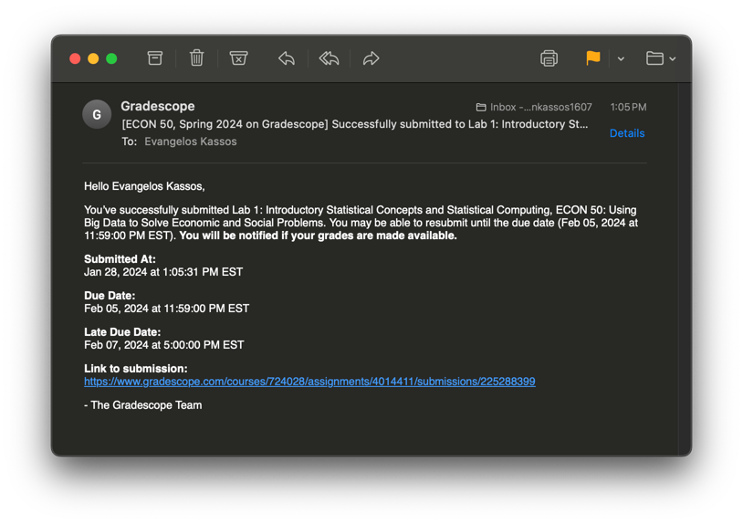 |

## What files to submit

|  |  |
|--|--|
| **If you’re using Python Notebook to write your R code, and a document editor to write your answers** <br><br> 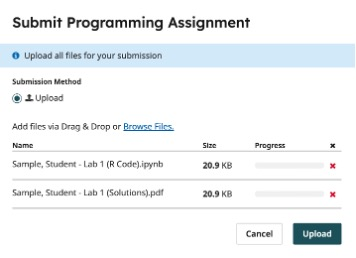| <ul><li>Submit your .ipynb R code file replicating all your analyses above (with enough comments that a principal investigator on a research project would be able to follow and understand what each step of the code is doing). We need your raw code so that we can run your code ourselves if needed.</li><li>Submit your answers as a .pdf file. **Do not submit a .doc/.docx file (Word document)**, as we are unable to read those files on Gradescope.</li></ul><br>_For graphs, always be sure to save them as images (e.g., .png files) and insert them into the answer document even if it was not explicitly asked._<br><br>**Important:** If we do not have both your .ipynb code and .pdf answer files, you will lose 1 out of the 3 lab assignment points.<br><br><span style="color:crimson">**Word of caution:**</span> <u>**Do not**</u> use Python to perform your analysis in this Lab, unless when explicitly instructed. You will receive no points if you’re not using R or Stata for your analysis.|
| **If you’re using a Python Notebook to write your R code AND to write your answers** <br><br> 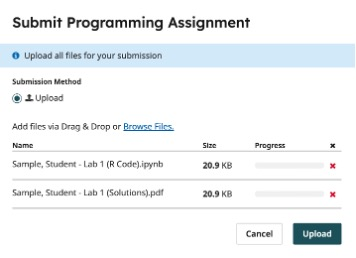| <ul><li>Submit your .ipynb R code file replicating all your analyses above (with enough comments that a principal investigator on a research project would be able to follow and understand what each step of the code is doing). We need your raw code so that we can run your code ourselves if needed.</li><li>Submit the .pdf version of your .ipynb file.</li></ul><br>_For graphs, always be sure to save them as images (either in the cell output or as separate images, such as .png files) and insert them into the answer document even if it was not explicitly asked._<br><br>**Important:** If we do not have both your .ipynb code and .pdf answer files, you will lose 1 out of the 3 lab assignment points.<br><br>**Do not submit ONLY the .ipynb file**, as we might have trouble reading your answers using those files on Gradescope.<br><br><span style="color:crimson">**Word of caution:**</span> <u>**Do not**</u> use Python to perform your analysis in this Lab, unless when explicitly instructed. You will receive no points if you’re not using R or Stata for your analysis.|png)|

## WHAT ARE DO-FILES AND .R FILES AND WHY DO WE NEED ONE?<span id="Dofiles" class="anchor"></span>

*Let’s imagine the following situation - you just found out you have to
present your results to a partner– all the averages you produced and
comparisons you made. Suppose you also found out that the data you had
used to produce all these results was not completely clean, and have
only just fixed it. You now have incorrect numbers and need to re-do
everything.*

*How would you go about it? Would you reproduce everything you did for
Lab 1 from scratch? Can you do it? How long would it take you to do?
Just re-typing all those commands into Stata or R in order and checking
them would take an hour.*

*An important feature of any good research project is that the results
should be reproducible. For Stata and R the easiest way to do this is to
create a text file that lists all your commands in order, so anyone can
re-run all your Stata or R work on a project anytime. Such text files
that are produced within Stata or linked to Stata are called do-files,
because they have an extension .do (like intro_exercise.do). Similarly,
in R, these files are called .R files because they have an extension of
.R. These files feed commands directly into Stata or R without you
having to type or copy them into the command window.*

*An added bonus is that having do-files and .R files makes it very easy
to fix your typos, re-order commands, and create more complicated chains
of commands that wouldn’t work otherwise. You can now quickly reproduce
your work, correct it, adjust it, and build on it.*

*Finally, do-files and .R files make it possible for multiple people to
work on a project, which is necessary for collaborating with others or
when you hand off a project to someone else.*

## DATA DESCRIPTION, FILE: health.dta

The data consist of 48,784 patient records. Variables that start with
tm1\_ were measured in the prior year (time $t - 1$). Variable that end
with \_t are measured in the current year. For more details on the
construction of the variables included in this data set, please see
[Obermeyer, Powers, Vogeli, and Mullainathan
(2019](https://science-sciencemag-org.ezp-prod1.hul.harvard.edu/content/366/6464/447)).

**TABLE 1**<span id="Table1" class="anchor"></span>

Variable Definitions

<table>
<colgroup>
<col style="width: 34%" />
<col style="width: 25%" />
<col style="width: 11%" />
<col style="width: 10%" />
<col style="width: 8%" />
<col style="width: 10%" />
</colgroup>
<thead>
<tr class="header">
<th><em> </em></th>
<th> </th>
<th> </th>
<th> </th>
<th> </th>
<th> </th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td><em>Variable</em></td>
<td>Description</td>
<td>mean</td>
<td>sd</td>
<td>min</td>
<td>max</td>
</tr>
<tr class="even">
<td><em>(1)</em></td>
<td>(2)</td>
<td>(3)</td>
<td>(4)</td>
<td>(5)</td>
<td>(6)</td>
</tr>
<tr class="odd">
<td><em> </em></td>
<td> </td>
<td> </td>
<td> </td>
<td> </td>
<td> </td>
</tr>
<tr class="even">
<td><em><strong>patient_id</strong></em></td>
<td>Patient identification number</td>
<td>n/a</td>
<td>n/a</td>
<td>n/a</td>
<td>n/a</td>
</tr>
<tr class="odd">
<td><em><strong>gagne_sum_t</strong></em></td>
<td>Total number of active chronic illnesses</td>
<td>1.354</td>
<td>1.942</td>
<td>0</td>
<td>17</td>
</tr>
<tr class="even">
<td><em><strong>cost_t</strong></em></td>
<td>Total medical expenditures, rounded to the nearest 100</td>
<td>7,660</td>
<td>17,990</td>
<td>0</td>
<td>550,500</td>
</tr>
<tr class="odd">
<td><em><strong>cost_avoidable_t</strong></em></td>
<td>Total avoidable (emergency + inpatient) medical expenditures, rounded to nearest</td>
<td>2,435</td>
<td>12,058</td>
<td>0</td>
<td>642,700</td>
</tr>
<tr class="even">
<td><em><strong>race</strong></em></td>
<td>String variable containing the words “black” and “white”</td>
<td>n/a</td>
<td>n/a</td>
<td>n/a</td>
<td>n/a</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_dem_black</strong></em></td>
<td><p>1 = Black</p>
<p>0 = White</p></td>
<td>0.114</td>
<td>0.318</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_dem_female</strong></em></td>
<td><p>1 = Female</p>
<p>0 = Male</p></td>
<td>0.631</td>
<td>0.483</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_dem_age_band_1824</strong></em></td>
<td>Indicator for patient age between 18-24</td>
<td>0.0369</td>
<td>0.188</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_dem_age_band_2534</strong></em></td>
<td>Indicator for patient age between 25-34</td>
<td>0.110</td>
<td>0.313</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_dem_age_band_3544</strong></em></td>
<td>Indicator for patient age between 35-44</td>
<td>0.194</td>
<td>0.396</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_dem_age_band_4554</strong></em></td>
<td>Indicator for patient age between 45-54</td>
<td>0.239</td>
<td>0.427</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_dem_age_band_5564</strong></em></td>
<td>Indicator for patient age between 55-64</td>
<td>0.197</td>
<td>0.397</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_dem_age_band_6574</strong></em></td>
<td>Indicator for patient age between 65-74</td>
<td>0.142</td>
<td>0.349</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_dem_age_band_75</strong></em></td>
<td>Indicator for patient age 75+</td>
<td>0.0703</td>
<td>0.256</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_alcohol_elixhauser</strong></em></td>
<td>Indicator for alcohol abuse</td>
<td>0.00892</td>
<td>0.0940</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_anemia_elixhauser</strong></em></td>
<td>Indicator for deficiency anemia</td>
<td>0.0636</td>
<td>0.244</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_arrhythmia_elixhauser</strong></em></td>
<td>Indicator for arrhythmia</td>
<td>0.0922</td>
<td>0.289</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_arthritis_elixhauser</strong></em></td>
<td>Indicator for arthritis</td>
<td>0.0466</td>
<td>0.211</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_bloodlossanemia_elixhauser</strong></em></td>
<td>Indicator for blood loss anemia</td>
<td>0.00246</td>
<td>0.0495</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_coagulopathy_elixhauser</strong></em></td>
<td>Indicator for coagulopathy</td>
<td>0.0115</td>
<td>0.107</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_compdiabetes_elixhauser</strong></em></td>
<td>Indicator for diabetes, complicated</td>
<td>0.0217</td>
<td>0.146</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_depression_elixhauser</strong></em></td>
<td>Indicator for depression</td>
<td>0.0621</td>
<td>0.241</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_drugabuse_elixhauser</strong></em></td>
<td>Indicator for drug abuse</td>
<td>0.00623</td>
<td>0.0787</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_electrolytes_elixhauser</strong></em></td>
<td>Indicator for electrolyte disorder</td>
<td>0.0329</td>
<td>0.178</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hypertension_elixhauser</strong></em></td>
<td>Indicator for hypertension</td>
<td>0.332</td>
<td>0.471</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hypothyroid_elixhauser</strong></em></td>
<td>Indicator for hypothyroid</td>
<td>0.0938</td>
<td>0.292</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_liver_elixhauser</strong></em></td>
<td>Indicator for liver disease</td>
<td>0.0159</td>
<td>0.125</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_neurodegen_elixhauser</strong></em></td>
<td>Indicator for neurodegenerative disease</td>
<td>0.0280</td>
<td>0.165</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_obesity_elixhauser</strong></em></td>
<td>Indicator for obesity</td>
<td>0.0929</td>
<td>0.290</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_paralysis_elixhauser</strong></em></td>
<td>Indicator for paralysis</td>
<td>0.000574</td>
<td>0.0240</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_psychosis_elixhauser</strong></em></td>
<td>Indicator for psychoses</td>
<td>0.0325</td>
<td>0.177</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_pulmcirc_elixhauser</strong></em></td>
<td>Indicator for pulmonary circulation disorders</td>
<td>0.00558</td>
<td>0.0745</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_pvd_elixhauser</strong></em></td>
<td>Indicator for peripheral vascular disorders</td>
<td>0.0263</td>
<td>0.160</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_renal_elixhauser</strong></em></td>
<td>Indicator for renal failure</td>
<td>0.0367</td>
<td>0.188</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_uncompdiabetes_elixhauser</strong></em></td>
<td>Indicator for diabetes, uncomplicated</td>
<td>0.0987</td>
<td>0.298</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_valvulardz_elixhauser</strong></em></td>
<td>Indicator for valvular disease</td>
<td>0.0315</td>
<td>0.175</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_wtloss_elixhauser</strong></em></td>
<td>Indicator for weight loss</td>
<td>0.00139</td>
<td>0.0373</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cerebrovasculardz_romano</strong></em></td>
<td>Indicator for cerebrovascular disease</td>
<td>0.0283</td>
<td>0.166</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_chf_romano</strong></em></td>
<td>Indicator for congestive heart failure</td>
<td>0.0319</td>
<td>0.176</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_dementia_romano</strong></em></td>
<td>Indicator for dementia</td>
<td>0.00949</td>
<td>0.0970</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hemiplegia_romano</strong></em></td>
<td>Indicator for hemiplegia</td>
<td>0.00266</td>
<td>0.0516</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hivaids_romano</strong></em></td>
<td>Indicator for HIV/AIDS</td>
<td>0.00305</td>
<td>0.0552</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_metastatic_romano</strong></em></td>
<td>Indicator for metastasis</td>
<td>0.00613</td>
<td>0.0780</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_myocardialinfarct_romano</strong></em></td>
<td>Indicator for myocardial infarction</td>
<td>0.0169</td>
<td>0.129</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_pulmonarydz_romano</strong></em></td>
<td>Indicator for pulmonary disease</td>
<td>0.102</td>
<td>0.302</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_tumor_romano</strong></em></td>
<td>Indicator for tumor</td>
<td>0.0944</td>
<td>0.292</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ulcer_romano</strong></em></td>
<td>Indicator for ulcer</td>
<td>0.00480</td>
<td>0.0691</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_dialysis</strong></em></td>
<td>Total costs for dialysis, rounded to nearest 10</td>
<td>26.72</td>
<td>976.6</td>
<td>0</td>
<td>63,410</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cost_emergency</strong></em></td>
<td>Total costs for emergency, rounded to nearest 10</td>
<td>423.7</td>
<td>1,572</td>
<td>0</td>
<td>67,090</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_home_health</strong></em></td>
<td>Total costs for home health, rounded to nearest 10</td>
<td>220.5</td>
<td>1,396</td>
<td>0</td>
<td>56,830</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cost_ip_medical</strong></em></td>
<td>Total costs for inpatient medical, rounded to nearest 10</td>
<td>638.8</td>
<td>4,570</td>
<td>0</td>
<td>282,300</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_ip_surgical</strong></em></td>
<td>Total costs for inpatient surgical, rounded to nearest 10</td>
<td>978.5</td>
<td>6,575</td>
<td>0</td>
<td>279,930</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cost_laboratory</strong></em></td>
<td>Total costs for laboratory, rounded to nearest 10</td>
<td>330.9</td>
<td>949.4</td>
<td>-490</td>
<td>62,720</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_op_primary_care</strong></em></td>
<td>Total costs for outpatient primary care, rounded to nearest 10</td>
<td>473.9</td>
<td>1,872</td>
<td>0</td>
<td>240,290</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cost_op_specialists</strong></em></td>
<td>Total costs for outpatient specialists, rounded to nearest 10</td>
<td>866.2</td>
<td>1,546</td>
<td>0</td>
<td>41,720</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_op_surgery</strong></em></td>
<td>Total costs for outpatient surgery, rounded to nearest 10</td>
<td>846.6</td>
<td>2,659</td>
<td>0</td>
<td>75,790</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cost_other</strong></em></td>
<td>Total other costs, rounded to nearest 100</td>
<td>1,569</td>
<td>4,639</td>
<td>0</td>
<td>193,200</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_pharmacy</strong></em></td>
<td>Total costs for pharmacy, rounded to nearest 10</td>
<td>342.5</td>
<td>3,995</td>
<td>-10</td>
<td>153,250</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cost_physical_therapy</strong></em></td>
<td>Total costs for physical therapy, rounded to nearest 10</td>
<td>167.2</td>
<td>534.0</td>
<td>0</td>
<td>10,240</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cost_radiology</strong></em></td>
<td>Total costs for radiology, rounded to nearest 10</td>
<td>241.1</td>
<td>580.8</td>
<td>0</td>
<td>20,710</td>
</tr>
<tr class="even">
<td><em><strong>tm1_lasix_dose_count</strong></em></td>
<td>Number of Lasix doses</td>
<td>0.0182</td>
<td>0.228</td>
<td>0</td>
<td>9</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_lasix_min_daily_dose</strong></em></td>
<td>Minimum daily dose of Lasix</td>
<td>0.353</td>
<td>4.370</td>
<td>0</td>
<td>200</td>
</tr>
<tr class="even">
<td><em><strong>tm1_lasix_mean_daily_dose</strong></em></td>
<td>Mean daily dose of Lasix</td>
<td>0.378</td>
<td>4.535</td>
<td>0</td>
<td>160</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_lasix_max_daily_dose</strong></em></td>
<td>Maximum daily dose of Lasix</td>
<td>0.418</td>
<td>5.247</td>
<td>0</td>
<td>200</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cre_tests</strong></em></td>
<td>Number of c-reatinine tests</td>
<td>1.237</td>
<td>3.396</td>
<td>0</td>
<td>166</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_crp_tests</strong></em></td>
<td>Number of c-reactive protein tests</td>
<td>0.000471</td>
<td>0.0226</td>
<td>0</td>
<td>2</td>
</tr>
<tr class="even">
<td><em><strong>tm1_esr_tests</strong></em></td>
<td>Number of erythrocyte sedimentation rate tests</td>
<td>0.113</td>
<td>0.538</td>
<td>0</td>
<td>13</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ghba1c_tests</strong></em></td>
<td>Number of GHbA1c tests</td>
<td>0.385</td>
<td>0.748</td>
<td>0</td>
<td>9</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hct_tests</strong></em></td>
<td>Number of hematocrit tests</td>
<td>1.089</td>
<td>3.140</td>
<td>0</td>
<td>164</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ldl_tests</strong></em></td>
<td>Number of LDL tests</td>
<td>0.520</td>
<td>0.701</td>
<td>0</td>
<td>10</td>
</tr>
<tr class="even">
<td><em><strong>tm1_nt_bnp_tests</strong></em></td>
<td>Number of BNP tests</td>
<td>0.0305</td>
<td>0.257</td>
<td>0</td>
<td>10</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_sodium_tests</strong></em></td>
<td>Number of sodium tests</td>
<td>1.156</td>
<td>3.237</td>
<td>0</td>
<td>122</td>
</tr>
<tr class="even">
<td><em><strong>tm1_trig_tests</strong></em></td>
<td>Number of triglycerides tests</td>
<td>0.483</td>
<td>0.681</td>
<td>0</td>
<td>12</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cre_minlow</strong></em></td>
<td>Indicator for low (&lt; 0.84) minimum creatinine test result</td>
<td>0.222</td>
<td>0.416</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cre_minhigh</strong></em></td>
<td>Indicator for high (&gt; 1.21) minimum creatinine test result</td>
<td>0.0391</td>
<td>0.194</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cre_minnormal</strong></em></td>
<td>Indicator for normal minimum creatinine test result</td>
<td>0.236</td>
<td>0.424</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cre_meanlow</strong></em></td>
<td>Indicator for low (&lt; 0.84) mean creatinine test result</td>
<td>0.200</td>
<td>0.400</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cre_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 1.21) mean creatinine test result</td>
<td>0.0512</td>
<td>0.220</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cre_meannormal</strong></em></td>
<td>Indicator for normal mean creatinine test result</td>
<td>0.245</td>
<td>0.430</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cre_maxlow</strong></em></td>
<td>Indicator for low (&lt; 0.84) maximum creatinine test result</td>
<td>0.178</td>
<td>0.383</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_cre_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 1.21) maximum creatinine test result</td>
<td>0.0674</td>
<td>0.251</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_cre_maxnormal</strong></em></td>
<td>Indicator for normal maximum creatinine test result</td>
<td>0.252</td>
<td>0.434</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_crp_minlow</strong></em></td>
<td>Indicator for low (&lt; 1) minimum c-reactive protein test result</td>
<td>0.000164</td>
<td>0.0128</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_crp_minhigh</strong></em></td>
<td>Indicator for high (&gt; 3) minimum c-reactive protein test result</td>
<td>0.000164</td>
<td>0.0128</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_crp_minnormal</strong></em></td>
<td>Indicator for normal minimum c-reactive protein test result</td>
<td>6.15e-05</td>
<td>0.00784</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_crp_meanlow</strong></em></td>
<td>Indicator for low (&lt; 1) mean c-reactive protein test result</td>
<td>0.000164</td>
<td>0.0128</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_crp_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 3) mean c-reactive protein test result</td>
<td>0.000164</td>
<td>0.0128</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_crp_meannormal</strong></em></td>
<td>Indicator for normal mean c-reactive protein test result</td>
<td>6.15e-05</td>
<td>0.00784</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_crp_maxlow</strong></em></td>
<td>Indicator for low (&lt; 1) maximum c-reactive protein test result</td>
<td>0.000164</td>
<td>0.0128</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_crp_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 3) maximum c-reactive protein test result</td>
<td>0.000164</td>
<td>0.0128</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_crp_maxnormal</strong></em></td>
<td>Indicator for normal maximum c-reactive protein test result</td>
<td>6.15e-05</td>
<td>0.00784</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_esr_minlow</strong></em></td>
<td>Indicator for low (&lt; 1) minimum erythrocyte sedimentation rate test result</td>
<td>0</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr class="even">
<td><em><strong>tm1_esr_minhigh</strong></em></td>
<td>Indicator for high (&gt; 20) minimum erythrocyte sedimentation rate test result</td>
<td>0.0218</td>
<td>0.146</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_esr_minnormal</strong></em></td>
<td>Indicator for normal minimum erythrocyte sedimentation rate test result</td>
<td>0.0514</td>
<td>0.221</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_esr_meanlow</strong></em></td>
<td>Indicator for low (&lt; 1) mean erythrocyte sedimentation rate test result</td>
<td>0</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_esr_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 20) mean erythrocyte sedimentation rate test result</td>
<td>0.0245</td>
<td>0.155</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_esr_meannormal</strong></em></td>
<td>Indicator for normal mean erythrocyte sedimentation rate test result</td>
<td>0.0487</td>
<td>0.215</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_esr_maxlow</strong></em></td>
<td>Indicator for low (&lt; 1) maximum erythrocyte sedimentation rate test result</td>
<td>0</td>
<td>0</td>
<td>0</td>
<td>0</td>
</tr>
<tr class="even">
<td><em><strong>tm1_esr_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 20) maximum erythrocyte sedimentation rate test result</td>
<td>0.0265</td>
<td>0.161</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_esr_maxnormal</strong></em></td>
<td>Indicator for normal maximum erythrocyte sedimentation rate test result</td>
<td>0.0470</td>
<td>0.212</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ghba1c_minlow</strong></em></td>
<td>Indicator for low (&lt; 4) minimum GHbA1c test result</td>
<td>4.10e-05</td>
<td>0.00640</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ghba1c_minhigh</strong></em></td>
<td>Indicator for high (&gt; 5.7) minimum GHbA1c test result</td>
<td>0.123</td>
<td>0.329</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ghba1c_minnormal</strong></em></td>
<td>Indicator for normal minimum GHbA1c test result</td>
<td>0.146</td>
<td>0.353</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ghba1c_meanlow</strong></em></td>
<td>Indicator for low (&lt; 4) mean GHbA1c test result</td>
<td>4.10e-05</td>
<td>0.00640</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ghba1c_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 5.7) mean GHbA1c test result</td>
<td>0.130</td>
<td>0.336</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ghba1c_meannormal</strong></em></td>
<td>Indicator for normal mean GHbA1c test result</td>
<td>0.140</td>
<td>0.347</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ghba1c_maxlow</strong></em></td>
<td>Indicator for low (&lt; 4) maximum GHbA1c test result</td>
<td>4.10e-05</td>
<td>0.00640</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ghba1c_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 5.7) maximum GHbA1c test result</td>
<td>0.133</td>
<td>0.339</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ghba1c_maxnormal</strong></em></td>
<td>Indicator for normal maximum GHbA1c test result</td>
<td>0.137</td>
<td>0.344</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hct_minlow</strong></em></td>
<td>Indicator for low (&lt; 35.5) minimum hematocrit test result</td>
<td>0.0639</td>
<td>0.245</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hct_minhigh</strong></em></td>
<td>Indicator for high (&gt; 48.6) minimum hematocrit test result</td>
<td>0.00679</td>
<td>0.0821</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hct_minnormal</strong></em></td>
<td>Indicator for normal minimum hematocrit test result</td>
<td>0.375</td>
<td>0.484</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hct_meanlow</strong></em></td>
<td>Indicator for low (&lt; 35.5) mean hematocrit test result</td>
<td>0.0424</td>
<td>0.202</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hct_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 48.6) mean hematocrit test result</td>
<td>0.00787</td>
<td>0.0884</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hct_meannormal</strong></em></td>
<td>Indicator for normal mean hematocrit test result</td>
<td>0.396</td>
<td>0.489</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hct_maxlow</strong></em></td>
<td>Indicator for low (&lt; 35.5) maximum hematocrit test result</td>
<td>0.0242</td>
<td>0.154</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_hct_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 48.6) maximum hematocrit test result</td>
<td>0.0119</td>
<td>0.109</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_hct_maxnormal</strong></em></td>
<td>Indicator for normal maximum hematocrit test result</td>
<td>0.410</td>
<td>0.492</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ldl_minlow</strong></em></td>
<td>Indicator for low (&lt; 50) minimum LDL test result</td>
<td>0.0155</td>
<td>0.124</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ldl_minhigh</strong></em></td>
<td>Indicator for high (&gt; 99) minimum LDL test result</td>
<td>0.204</td>
<td>0.403</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ldl_minnormal</strong></em></td>
<td>Indicator for normal minimum LDL test result</td>
<td>0.198</td>
<td>0.398</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ldlmeanlow</strong></em></td>
<td>Indicator for low (&lt; 50) mean LDL test result</td>
<td>0.0127</td>
<td>0.112</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ldlmeanhigh</strong></em></td>
<td>Indicator for high (&gt; 99) mean LDL test result</td>
<td>0.211</td>
<td>0.408</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ldlmeannormal</strong></em></td>
<td>Indicator for normal mean LDL test result</td>
<td>0.134</td>
<td>0.340</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ldl_maxlow</strong></em></td>
<td>Indicator for low (&lt; 50) maximum LDL test result</td>
<td>0.0117</td>
<td>0.108</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_ldl_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 99) maximum LDL test result</td>
<td>0.218</td>
<td>0.413</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_ldl_maxnormal</strong></em></td>
<td>Indicator for normal maximum LDL test result</td>
<td>0.127</td>
<td>0.333</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_nt_bnp_minlow</strong></em></td>
<td>Indicator for low (&lt; 100) minimum BNP test result</td>
<td>0.00488</td>
<td>0.0697</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_nt_bnp_minhigh</strong></em></td>
<td>Indicator for high (&gt; 450) minimum BNP test result</td>
<td>0.00980</td>
<td>0.0985</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_nt_bnp_minnormal</strong></em></td>
<td>Indicator for normal minimum BNP test result</td>
<td>0.00543</td>
<td>0.0735</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_nt_bnp_meanlow</strong></em></td>
<td>Indicator for low (&lt; 100) mean BNP test result</td>
<td>0.00668</td>
<td>0.0815</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_nt_bnp_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 450) mean BNP test result</td>
<td>0.0103</td>
<td>0.101</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_nt_bnp_meannormal</strong></em></td>
<td>Indicator for normal minimum BNP test result</td>
<td>0.00344</td>
<td>0.0586</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_nt_bnp_maxlow</strong></em></td>
<td>Indicator for low (&lt; 100) maximum BNP test result</td>
<td>0.00646</td>
<td>0.0801</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_nt_bnp_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 450) maximum BNP test result</td>
<td>0.0106</td>
<td>0.102</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_nt_bnp_maxnormal</strong></em></td>
<td>Indicator for normal minimum BNP test result</td>
<td>0.00344</td>
<td>0.0586</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_sodium_minlow</strong></em></td>
<td>Indicator for low (&lt; 135) minimum sodium test result</td>
<td>0.0403</td>
<td>0.197</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_sodium_minhigh</strong></em></td>
<td>Indicator for high (&gt; 145) minimum sodium test result</td>
<td>0.000615</td>
<td>0.0248</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_sodium_minnormal</strong></em></td>
<td>Indicator for normal minimum sodium test result</td>
<td>0.438</td>
<td>0.496</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_sodium_meanlow</strong></em></td>
<td>Indicator for low (&lt; 135) mean sodium test result</td>
<td>0.0196</td>
<td>0.139</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_sodium_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 145) mean sodium test result</td>
<td>0.000861</td>
<td>0.0293</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_sodium_meannormal</strong></em></td>
<td>Indicator for normal mean sodium test result</td>
<td>0.459</td>
<td>0.498</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_sodium_maxlow</strong></em></td>
<td>Indicator for low (&lt; 135) maximum sodium test result</td>
<td>0.0109</td>
<td>0.104</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_sodium_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 145) maximum sodium test result</td>
<td>0.00515</td>
<td>0.0715</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_sodium_maxnormal</strong></em></td>
<td>Indicator for normal maximum sodium test result</td>
<td>0.464</td>
<td>0.499</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_trig_minlow</strong></em></td>
<td>Indicator for low (&lt; 50) minimum triglycerides test result</td>
<td>0.0318</td>
<td>0.176</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_trig_minhigh</strong></em></td>
<td>Indicator for high (&gt; 150) minimum triglycerides test result</td>
<td>0.0901</td>
<td>0.286</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_trig_minnormal</strong></em></td>
<td>Indicator for normal minimum triglycerides test result</td>
<td>0.262</td>
<td>0.440</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_trig_meanlow</strong></em></td>
<td>Indicator for low (&lt; 50) mean triglycerides test result</td>
<td>0.0289</td>
<td>0.167</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_trig_meanhigh</strong></em></td>
<td>Indicator for high (&gt; 150) mean triglycerides test result</td>
<td>0.0972</td>
<td>0.296</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_trig_meannormal</strong></em></td>
<td>Indicator for normal mean triglycerides test result</td>
<td>0.256</td>
<td>0.436</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_trig_maxlow</strong></em></td>
<td>Indicator for low (&lt; 50) maximum triglycerides test result</td>
<td>0.0279</td>
<td>0.165</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_trig_maxhigh</strong></em></td>
<td>Indicator for high (&gt; 150) maximum triglycerides test result</td>
<td>0.107</td>
<td>0.309</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="odd">
<td><em><strong>tm1_trig_maxnormal</strong></em></td>
<td>Indicator for normal maximum triglycerides test result</td>
<td>0.251</td>
<td>0.434</td>
<td>0</td>
<td>1</td>
</tr>
<tr class="even">
<td><em><strong>tm1_gagne_sum</strong></em></td>
<td>Total number of active illnesses</td>
<td>1.443</td>
<td>2.049</td>
<td>0</td>
<td>18</td>
</tr>
<tr class="odd">
<td><em> </em></td>
<td> </td>
<td> </td>
<td> </td>
<td> </td>
<td> </td>
</tr>
</tbody>
</table>


**TABLE 2**<span id="Table2" class="anchor"></span>

R Commands

See assignment PDF.